In [1]:
import kagglehub

path = kagglehub.dataset_download(
    "blastchar/telco-customer-churn"
)
print(path)

/Users/sanjaysriram/Documents/ml/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 172k/172k [00:00<00:00, 220kB/s]

Extracting files...
/Users/sanjaysriram/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


## Dataset Overview

We begin by loading the Telco Customer Churn dataset and inspecting its
basic structure. The goal here is to understand the size of the data,
the available features, and the target variable before any modeling
decisions are made.


In [3]:
import pandas as pd 
df = pd.read_csv(path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Feature Types and Schema

At this stage, we identify:
- Categorical features (contract types, services, payment methods)
- Numerical features (tenure, charges)
- The binary target variable (Churn)

This separation informs later preprocessing and feature engineering.


In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [43]:
print("Numerical columns:\n")  
for col in df.columns:
    if(df[col].dtype== 'int64' or df[col].dtype== 'float64'):
        print(col)

print("\nCategorical columns:\n")
for col in df.columns:
    if(df[col].dtype== 'object'):
        print(col)
        
        

Numerical columns:

SeniorCitizen
tenure
MonthlyCharges

Categorical columns:

customerID
gender
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
TotalCharges
Churn


In [45]:
df["Churn"].value_counts(normalize=True)


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

## Class Imbalance

The target variable is imbalanced, with churners forming a minority of
the dataset. This has important implications for:
- Model evaluation metrics
- Threshold selection
- Class imbalance handling during training


In [54]:
#Univariate Analysis

print(df['tenure'].describe())
print("\n")

print(df["MonthlyCharges"].describe())
print("\n")



count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64




Numerical Features

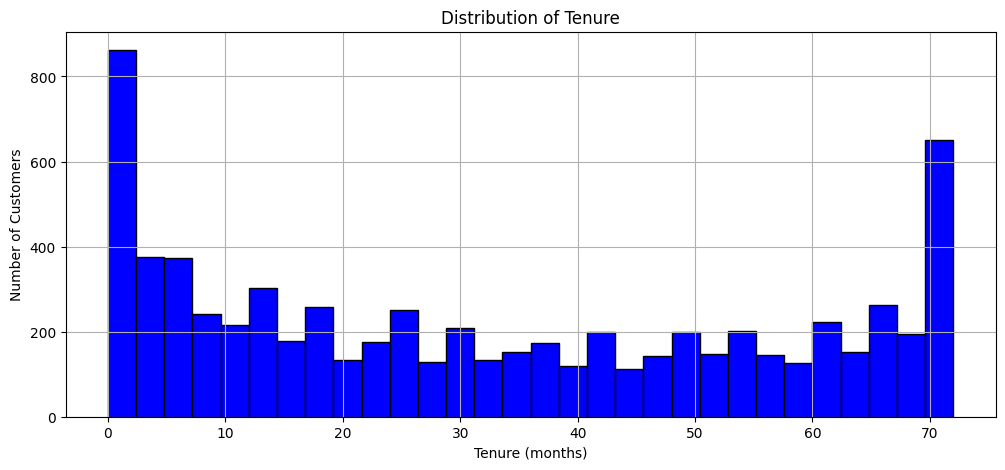

In [56]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12,5))
plt.hist(df["tenure"], bins = 30, color='blue', edgecolor='black')
plt.title("Distribution of Tenure")
plt.xlabel("Tenure (months)")
plt.ylabel("Number of Customers")
plt.grid()
plt.show()


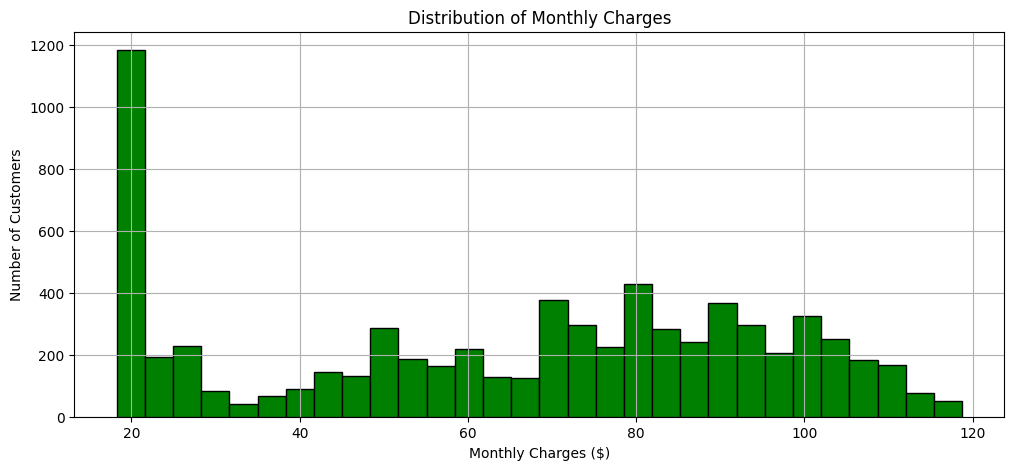

In [57]:
plt.figure(figsize=(12,5))
plt.hist(df["MonthlyCharges"], bins = 30, color='green', edgecolor='black')
plt.title("Distribution of Monthly Charges")
plt.xlabel("Monthly Charges ($)")
plt.ylabel("Number of Customers")
plt.grid()
plt.show()


In [79]:
df["TotalCharges"].dtype


dtype('O')

In [78]:
df["TotalCharges"].unique().shape

(6531,)

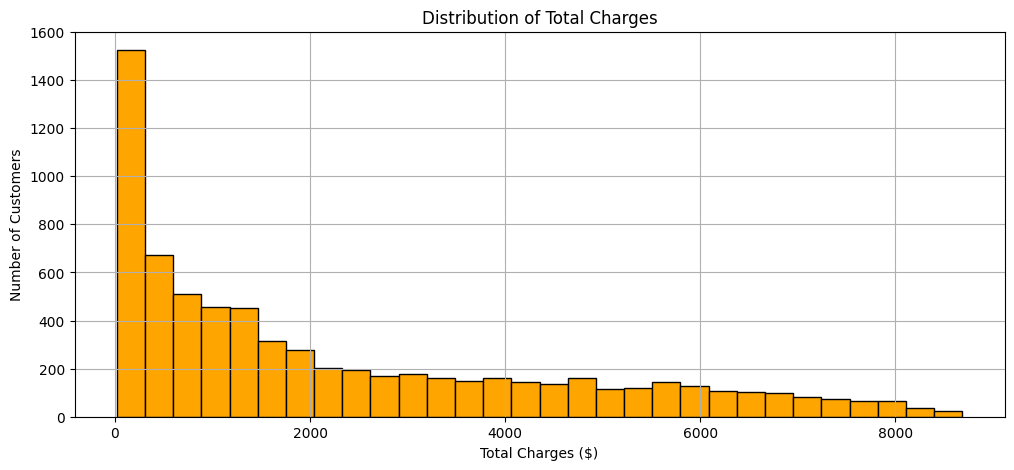

In [80]:
plt.figure(figsize=(12,5))
plt.hist(pd.to_numeric(df["TotalCharges"], errors='coerce').dropna(), bins = 30, color='orange', edgecolor='black')
plt.title("Distribution of Total Charges")
plt.xlabel("Total Charges ($)")
plt.ylabel("Number of Customers")
plt.grid()
plt.show()

TAKEAWAY: 
Although tenure and MonthlyCharges are numerical features, their distributions and expected relationships with churn suggest non-linear effects. In particular, the impact of tenure on churn risk is not constant across its range: customers in their initial months exhibit significantly higher churn risk, while additional months beyond long tenure contribute diminishing reductions in churn probability. Similarly, MonthlyCharges reflects discrete pricing tiers rather than a smooth linear progression, indicating threshold-based behavior where churn risk may change sharply at certain price levels. Since logistic regression assumes a linear relationship between features and the log-odds of the target, these patterns violate its constant-effect assumption. Tree-based models are better suited to capture such non-linear, piecewise relationships, while logistic regression may require feature engineering (e.g., tenure bucketing) to model these effects effectively.

The distribution of TotalCharges is heavily right-skewed, with a high concentration of customers having low accumulated charges and a long tail corresponding to long-tenure customers. This pattern is expected, as total charges are largely determined by customer tenure and monthly billing amount. No unrealistic or negative values are observed, confirming that the feature represents a valid continuous numerical variable. The strong skewness suggests that this feature reflects cumulative customer value rather than short-term behavior.Due to its strong dependence on tenure and monthly charges, TotalCharges introduces significant redundancy. For linear models, this feature will be excluded to avoid multicollinearity, while tree-based models may optionally retain it.
 


Categorical features

Categorical columns:

customerID
gender
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
TotalCharges
Churn

In [60]:
df["gender"].value_counts(normalize=True)

gender
Male      0.504756
Female    0.495244
Name: proportion, dtype: float64

In [61]:
df["Partner"].value_counts(normalize=True)

Partner
No     0.516967
Yes    0.483033
Name: proportion, dtype: float64

In [62]:
df["Dependents"].value_counts(normalize=True)

Dependents
No     0.700412
Yes    0.299588
Name: proportion, dtype: float64

In [63]:
df["PhoneService"].value_counts(normalize=True)

PhoneService
Yes    0.903166
No     0.096834
Name: proportion, dtype: float64

In [64]:
df["MultipleLines"].value_counts(normalize=True)

MultipleLines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: proportion, dtype: float64

In [65]:
df["InternetService"].value_counts(normalize=True)

InternetService
Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: proportion, dtype: float64

In [66]:
df["OnlineSecurity"].value_counts(normalize=True)

OnlineSecurity
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: proportion, dtype: float64

In [67]:
df["OnlineBackup"].value_counts(normalize=True)

OnlineBackup
No                     0.438450
Yes                    0.344881
No internet service    0.216669
Name: proportion, dtype: float64

In [68]:
df["DeviceProtection"].value_counts(normalize=True)

DeviceProtection
No                     0.439443
Yes                    0.343888
No internet service    0.216669
Name: proportion, dtype: float64

In [70]:
df["TechSupport"].value_counts(normalize=True)

TechSupport
No                     0.493114
Yes                    0.290217
No internet service    0.216669
Name: proportion, dtype: float64

In [71]:
df["StreamingTV"].value_counts(normalize=True)

StreamingTV
No                     0.398978
Yes                    0.384353
No internet service    0.216669
Name: proportion, dtype: float64

In [72]:
df["StreamingMovies"].value_counts(normalize=True)

StreamingMovies
No                     0.395428
Yes                    0.387903
No internet service    0.216669
Name: proportion, dtype: float64

In [73]:
df["Contract"].value_counts(normalize=True)

Contract
Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: proportion, dtype: float64

In [74]:
df["PaperlessBilling"].value_counts(normalize=True)

PaperlessBilling
Yes    0.592219
No     0.407781
Name: proportion, dtype: float64

In [75]:
df["PaymentMethod"].value_counts(normalize=True)

PaymentMethod
Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: proportion, dtype: float64

In [77]:
df["TotalCharges"].value_counts(normalize=True)

TotalCharges
          0.001562
20.2      0.001562
19.75     0.001278
20.05     0.001136
19.9      0.001136
            ...   
6849.4    0.000142
692.35    0.000142
130.15    0.000142
3211.9    0.000142
6844.5    0.000142
Name: proportion, Length: 6531, dtype: float64

TAKEAWAYS: The categorical features exhibit varying degrees of balance and structural dependency. Demographic variables such as gender and partner status are relatively balanced, while service-related features show clear segmentation. Notably, several add-on services contain a “No internet service” category, indicating conditional dependence on InternetService rather than independent customer choice. Contract type is heavily skewed toward month-to-month plans, which is a known strong churn indicator. These patterns suggest that tree-based models will be well-suited to capture interactions and conditional effects, while logistic regression will require careful one-hot encoding and may benefit from feature grouping.

Bivariate Analysis for numerical features

/var/folders/6j/222kp_qj7911r2zqsq4792dm0000gn/T/ipykernel_9285/3379436268.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tenure_no_churn, tenure_churn], labels=['No Churn', 'Churn'], patch_artist=True)


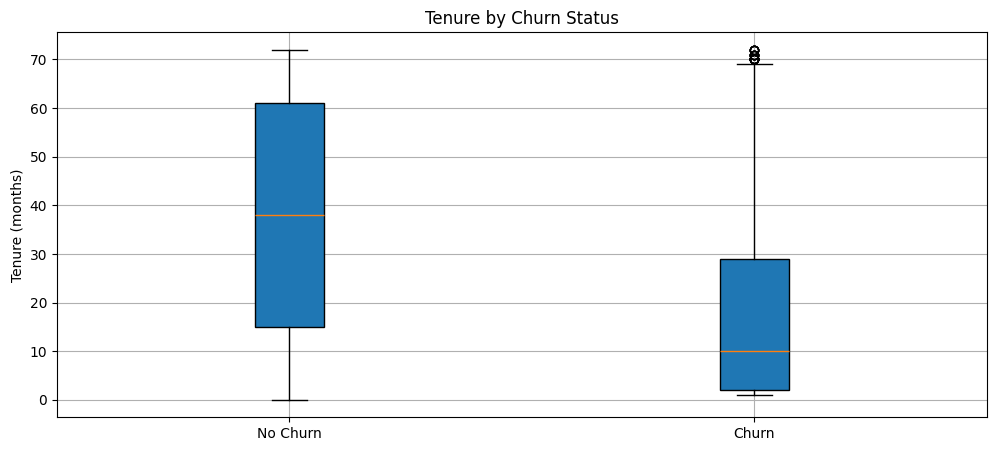

In [81]:
tenure_no_churn = df[df["Churn"] == "No"]["tenure"]
tenure_churn = df[df["Churn"] == "Yes"]["tenure"]

plt.figure(figsize=(12,5))
plt.boxplot([tenure_no_churn, tenure_churn], labels=['No Churn', 'Churn'], patch_artist=True)
plt.title("Tenure by Churn Status")
plt.ylabel("Tenure (months)")
plt.grid()
plt.show()


/var/folders/6j/222kp_qj7911r2zqsq4792dm0000gn/T/ipykernel_9285/2972154826.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([monthly_charges_no_churn, monthly_charges_churn], labels=['No Churn', 'Churn'], patch_artist=True)


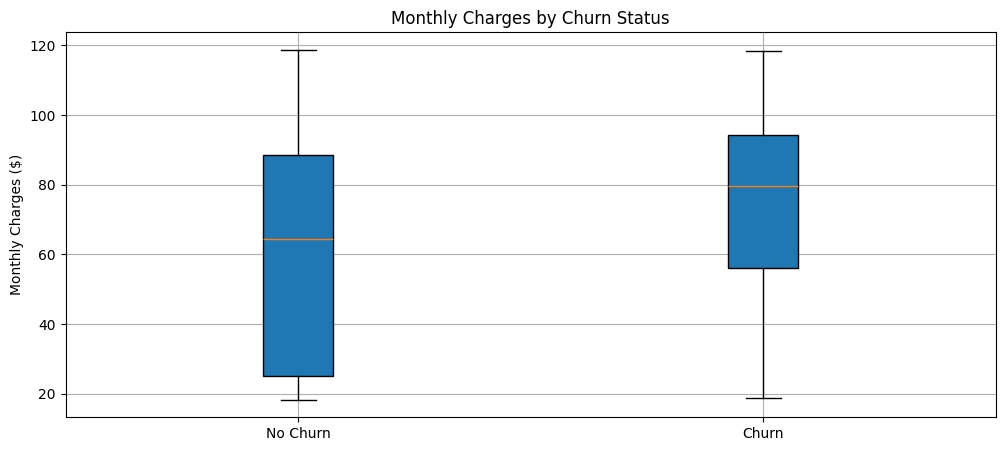

In [82]:
plt.figure(figsize=(12,5))
monthly_charges_no_churn = df[df["Churn"] == "No"]["MonthlyCharges"]
monthly_charges_churn = df[df["Churn"] == "Yes"]["MonthlyCharges"]
plt.boxplot([monthly_charges_no_churn, monthly_charges_churn], labels=['No Churn', 'Churn'], patch_artist=True)
plt.title("Monthly Charges by Churn Status")
plt.ylabel("Monthly Charges ($)")
plt.grid()
plt.show()

/var/folders/6j/222kp_qj7911r2zqsq4792dm0000gn/T/ipykernel_9285/2173842947.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([Total_charges_no_churn, Total_charges_churn], labels=['No Churn', 'Churn'], patch_artist=True)


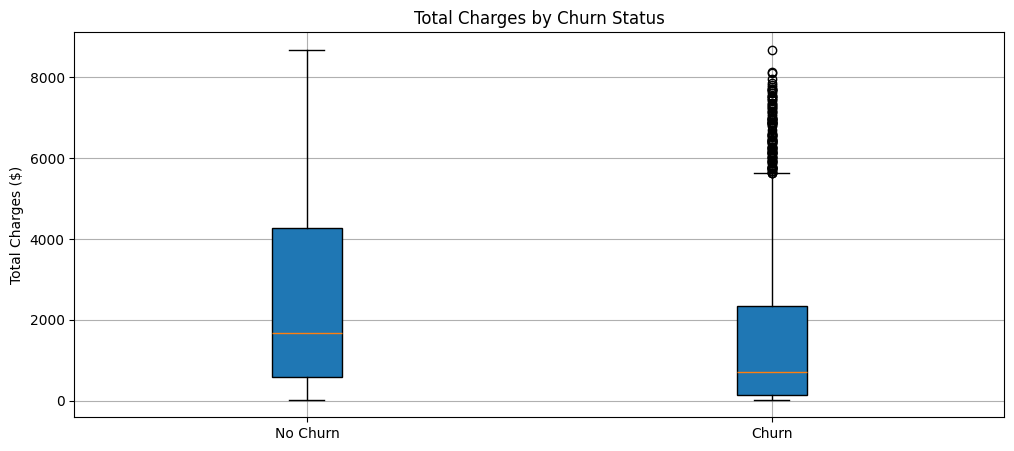

In [83]:
Total_charges_no_churn = df[df["Churn"] == "No"]["TotalCharges"].apply(pd.to_numeric, errors='coerce').dropna()
Total_charges_churn = df[df["Churn"] == "Yes"]["TotalCharges"].apply(pd.to_numeric, errors='coerce').dropna()
plt.figure(figsize=(12,5))
plt.boxplot([Total_charges_no_churn, Total_charges_churn], labels=['No Churn', 'Churn'], patch_artist=True)
plt.title("Total Charges by Churn Status")
plt.ylabel("Total Charges ($)")
plt.grid()
plt.show()

TAKEAWAYS: Among the numerical features, tenure demonstrates the strongest relationship with churn, showing clear separation and minimal overlap between churned and retained customers. MonthlyCharges provides moderate predictive signal but exhibits substantial overlap, suggesting that its value lies primarily in interaction with other features. TotalCharges offers the weakest standalone contribution due to its cumulative nature and strong redundancy with tenure.

Bivariate Analysis for Categorical Variables

Categorical columns:

customerID
gender
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
TotalCharges
Churn

In [84]:
df.groupby("gender")["Churn"].value_counts(normalize=True)

gender  Churn
Female  No       0.730791
        Yes      0.269209
Male    No       0.738397
        Yes      0.261603
Name: proportion, dtype: float64

In [85]:
df.groupby("Partner")["Churn"].value_counts(normalize=True)

Partner  Churn
No       No       0.670420
         Yes      0.329580
Yes      No       0.803351
         Yes      0.196649
Name: proportion, dtype: float64

In [86]:
df.groupby("Dependents")["Churn"].value_counts(normalize=True)

Dependents  Churn
No          No       0.687209
            Yes      0.312791
Yes         No       0.845498
            Yes      0.154502
Name: proportion, dtype: float64

In [87]:
df.groupby("PhoneService")["Churn"].value_counts(normalize=True)

PhoneService  Churn
No            No       0.750733
              Yes      0.249267
Yes           No       0.732904
              Yes      0.267096
Name: proportion, dtype: float64

In [88]:
df.groupby("MultipleLines")["Churn"].value_counts(normalize=True)

MultipleLines     Churn
No                No       0.749558
                  Yes      0.250442
No phone service  No       0.750733
                  Yes      0.249267
Yes               No       0.713901
                  Yes      0.286099
Name: proportion, dtype: float64

In [89]:
df.groupby("InternetService")["Churn"].value_counts(normalize=True)

InternetService  Churn
DSL              No       0.810409
                 Yes      0.189591
Fiber optic      No       0.581072
                 Yes      0.418928
No               No       0.925950
                 Yes      0.074050
Name: proportion, dtype: float64

In [90]:
df.groupby("OnlineSecurity")["Churn"].value_counts(normalize=True)

OnlineSecurity       Churn
No                   No       0.582333
                     Yes      0.417667
No internet service  No       0.925950
                     Yes      0.074050
Yes                  No       0.853888
                     Yes      0.146112
Name: proportion, dtype: float64

In [91]:
df.groupby("OnlineBackup")["Churn"].value_counts(normalize=True)

OnlineBackup         Churn
No                   No       0.600712
                     Yes      0.399288
No internet service  No       0.925950
                     Yes      0.074050
Yes                  No       0.784685
                     Yes      0.215315
Name: proportion, dtype: float64

In [92]:
df.groupby("DeviceProtection")["Churn"].value_counts(normalize=True)

DeviceProtection     Churn
No                   No       0.608724
                     Yes      0.391276
No internet service  No       0.925950
                     Yes      0.074050
Yes                  No       0.774979
                     Yes      0.225021
Name: proportion, dtype: float64

In [93]:
df.groupby("TechSupport")["Churn"].value_counts(normalize=True)

TechSupport          Churn
No                   No       0.583645
                     Yes      0.416355
No internet service  No       0.925950
                     Yes      0.074050
Yes                  No       0.848337
                     Yes      0.151663
Name: proportion, dtype: float64

In [94]:
df.groupby("StreamingTV")["Churn"].value_counts(normalize=True)

StreamingTV          Churn
No                   No       0.664769
                     Yes      0.335231
No internet service  No       0.925950
                     Yes      0.074050
Yes                  No       0.699298
                     Yes      0.300702
Name: proportion, dtype: float64

In [95]:
df.groupby("StreamingMovies")["Churn"].value_counts(normalize=True)

StreamingMovies      Churn
No                   No       0.663196
                     Yes      0.336804
No internet service  No       0.925950
                     Yes      0.074050
Yes                  No       0.700586
                     Yes      0.299414
Name: proportion, dtype: float64

In [96]:
df.groupby("Contract")["Churn"].value_counts(normalize=True)

Contract        Churn
Month-to-month  No       0.572903
                Yes      0.427097
One year        No       0.887305
                Yes      0.112695
Two year        No       0.971681
                Yes      0.028319
Name: proportion, dtype: float64

In [98]:
df.groupby("PaperlessBilling")["Churn"].value_counts(normalize=True)

PaperlessBilling  Churn
No                No       0.836699
                  Yes      0.163301
Yes               No       0.664349
                  Yes      0.335651
Name: proportion, dtype: float64

In [99]:
df.groupby("PaymentMethod")["Churn"].value_counts(normalize=True)

PaymentMethod              Churn
Bank transfer (automatic)  No       0.832902
                           Yes      0.167098
Credit card (automatic)    No       0.847569
                           Yes      0.152431
Electronic check           No       0.547146
                           Yes      0.452854
Mailed check               No       0.808933
                           Yes      0.191067
Name: proportion, dtype: float64

TAKEAWAYS: Several categorical features exhibit strong relationships with churn. Contract type is the most influential predictor, with month-to-month customers showing significantly higher churn rates compared to long-term contracts. InternetService and service add-ons such as TechSupport and OnlineSecurity also demonstrate substantial churn rate differences, indicating that service quality and support play a critical role in retention. Payment behavior further influences churn, with electronic check users exhibiting the highest churn. In contrast, demographic features such as gender and basic phone service show minimal predictive value.

Multivariate Analysis for Numerical Features

In [101]:
heat_df = df[["tenure", "MonthlyCharges", "TotalCharges"]].dropna().apply(pd.to_numeric, errors='coerce')
corr = heat_df.corr()
print(corr)

                 tenure  MonthlyCharges  TotalCharges
tenure          1.00000        0.247900      0.825880
MonthlyCharges  0.24790        1.000000      0.651065
TotalCharges    0.82588        0.651065      1.000000


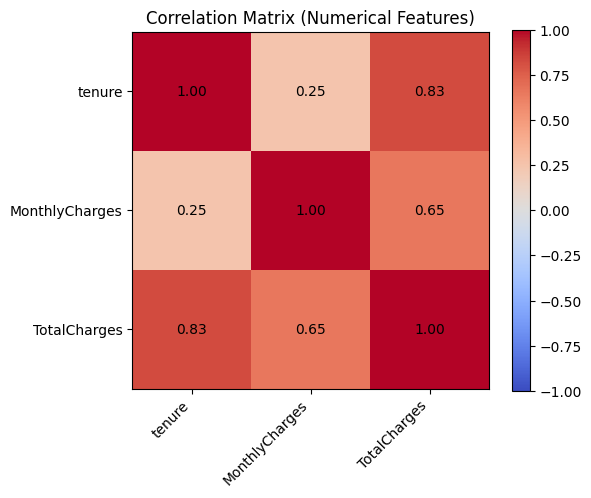

In [103]:
import numpy as np
fig, ax = plt.subplots(figsize=(6,5))

cax = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)


fig.colorbar(cax)

#
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))

ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right")


for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}",
                ha="center", va="center", color="black")

ax.set_title("Correlation Matrix (Numerical Features)")
plt.tight_layout()
plt.show()

The correlation matrix shows a strong positive correlation between
`tenure` and `TotalCharges` (ρ = 0.83), indicating significant
multicollinearity. This is expected, as TotalCharges is effectively
a cumulative function of tenure and monthly spending.

`MonthlyCharges` and `tenure` exhibit weak correlation (ρ = 0.25),
suggesting they provide largely independent information.

To avoid multicollinearity in linear models, `TotalCharges` will be
excluded from baseline modeling, while `tenure` and `MonthlyCharges`
will be retained.

TotalCharges was dropped due to high correlation with tenure and risk of data leakage.
TotalCharges represents cumulative spending over a customer’s lifetime and implicitly encodes churn behavior (customers who churn early naturally have lower total charges). Since this information would not be fully available at prediction time, retaining this feature could artificially inflate model performance and reduce real-world validity.


> **EDA Summary**

> Exploratory data analysis revealed that customer churn is a moderately imbalanced binary target, making accuracy an unreliable evaluation metric and motivating the use of ROC-AUC, precision, recall, and F1 score. Tenure emerged as the strongest numerical predictor, with churn occurring predominantly among early-stage customers, while MonthlyCharges showed a moderate relationship with churn, likely through interactions with contract type and service usage. Among categorical features, contract type, internet service, add-on services such as TechSupport and OnlineSecurity, and payment method demonstrated substantial differences in churn rates and strong business relevance, whereas demographic variables such as gender showed minimal predictive value. Multivariate analysis identified TotalCharges as a redundant and potentially leaky feature due to its strong dependence on tenure and cumulative customer history, leading to its exclusion from modeling. Overall, the dataset is clean, exhibits no invalid outliers, and is well-suited for churn prediction using interaction-aware models, with class imbalance to be addressed during the modeling stage rather than during EDA.
